In [7]:
""" New features to add 
Calculations 
1. Add Option's, using amount for ones that have been opened and closed *100 
2. Add Option's for positons that are still open. 
3. Could Add bitcoin returns? 

Analytics 

4. Portfolio Beta 
 

Graphing 
2. Position Correlations 
3.  
4. Asset allocation to sector


Statistics 
1. Monte Carlo 
2. Value at Risk 
----------------------------------------------------------------------------------------------------------------
Options Feature
1. Implied Volatility Skew 
2. Volatility Surface
3. Options Profit Calculator
    - Pay off structure
    - Break Even
4. Unusual Options 
5. Option Interest
----------------------------------------------------------------------------------------------------------------
Bonds Features 
1. Look at Bond Convexity 
2. Looks at Bond Returns? 

----------------------------------------------------------------------------------------------------------------
Create Website. 

1. Allows for all the holding to placed in a dashboard and consildation of stats 
2. Options Tab 
3. Bond Tab
4. Screener, and technical Screener
5. Charts for positions, and for other postions (include technicals if wanted on charts)
"""

" New features to add \nCalculations \n1. Add Option's, using amount for ones that have been opened and closed *100 \n2. Add Option's for positons that are still open. \n3. Could Add bitcoin returns? \n\nAnalytics \n\n4. Portfolio Beta \n \n\nGraphing \n2. Position Correlations \n3.  \n4. Asset allocation to sector\n\n\nStatistics \n1. Monte Carlo \n2. Value at Risk \n----------------------------------------------------------------------------------------------------------------\nOptions Feature\n1. Implied Volatility Skew \n2. Volatility Surface\n3. Options Profit Calculator\n    - Pay off structure\n    - Break Even\n4. Unusual Options \n5. Option Interest\n----------------------------------------------------------------------------------------------------------------\nBonds Features \n1. Look at Bond Convexity \n2. Looks at Bond Returns? \n\n----------------------------------------------------------------------------------------------------------------\nCreate Website. \n\n1. Allows

In [8]:
import pandas as pd
from datetime import datetime,timedelta
import logging
import yfinance as yf
logging.getLogger('yfinance').setLevel(logging.CRITICAL)
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.linear_model import LinearRegression
from pandas_datareader import data as wb
import seaborn as sns
from scipy.stats import norm

cash_balance = 3989.89 # also set cash balance in calculate cash balance function
trades_df = pd.read_excel("trades.xlsx") # rename excel file to trades.xlsx

In [9]:
warnings.simplefilter(action = "ignore",category = FutureWarning)

# starting date of trade 
trade_date = trades_df["DATE"][0].date()

# time of holdings
num_days = (datetime.today().date() - trade_date).days

# Define initial cash balance
initial_cash_balance = cash_balance

# Indicies 
indicies = ["SPY", "IWM", "QQQ"]

# 10 year government security
rf_rate = ["^TNX"]

# Load tickers
def load_tickers(tickers):
    df = yf.download(tickers=tickers, start=trade_date, end=datetime.today(),progress= False,show_errors= None)
    df2 = df["Close"]
    return df2

# Load closing prices of tickers
df = load_tickers(indicies)

# Calculate shares to buy for each index
index_prices = load_tickers(indicies).iloc[0]
index_shares = (initial_cash_balance // index_prices).astype(int)

# Calculate leftover cash after purchasing indices
IWM_leftover_cash = initial_cash_balance - (index_shares["IWM"] * index_prices["IWM"])
SPY_leftover_cash = initial_cash_balance - (index_shares["SPY"] * index_prices["SPY"])
QQQ_leftover_cash = initial_cash_balance - (index_shares["QQQ"] * index_prices["QQQ"])

# Calculate initial investment for each index
initial_investment = index_shares * index_prices
initial_investment["IWM"] += IWM_leftover_cash
initial_investment["SPY"] += SPY_leftover_cash
initial_investment["QQQ"] += QQQ_leftover_cash

# Calculate final value of each index
final_value = index_shares * load_tickers(indicies).iloc[-1]

# Calculate return of each index
index_returns = ((final_value / initial_investment) - 1) * 100 

# Initialize an empty DataFrame to store the final values for each index over time
final_values = pd.DataFrame(index=df.index, columns=indicies)

# Iterate through each date in the DataFrame
for date in df.index:
    # Calculate the final value for each index on the current date
    final_value = index_shares * df.loc[date, indicies]
    # Add the corresponding leftover cash to the final value for each index
    final_value["IWM"] += IWM_leftover_cash
    final_value["SPY"] += SPY_leftover_cash
    final_value["QQQ"] += QQQ_leftover_cash
    # Assign the final value to the DataFrame
    final_values.loc[date] = final_value

# Calculate index returns based on final values stored in final_values DataFrame
index_returns = ((final_values.iloc[-1] / final_values.iloc[0] - 1) * 100)

# download 10 year 
treasury_data = yf.download(rf_rate, start = trade_date, end = datetime.today().date(),progress= False)

# take the 10 year most recent price * (number of days held/ 365 days)
adj_rf_rate = treasury_data["Close"].iloc[-1]*(num_days/365)


# Function to calculate cash balance for each day
def calculate_cash_balance(df):
    cash_balance = 3989.89 + (357.5)
    
    # Initialize an empty list to store results
    result_data = []

    # Iterate over unique dates
    for date in df['DATE'].unique():
        # Filter rows for the current date
        daily_amounts = df[df['DATE'] == date]['AMOUNT'] 
        daily_commission = df[df["DATE"]== date]["COMMISSION"]
        daily_regfee = df[df["DATE"]== date]["REG FEE"]

        # Sum amounts for the current date
        daily_total = daily_amounts.sum() - (daily_commission.sum() + daily_regfee.sum())

        # Update cash balance
        cash_balance += daily_total

        # Append result to list
        result_data.append({'DATE': date, 'CASH_BALANCE': cash_balance})

    # Create DataFrame from the list of results
    result_df = pd.DataFrame(result_data)
    
    return result_df

# Load the data from trades.xlsx
df = pd.read_excel('trades.xlsx')

# Convert DATE column to datetime if not already
df['DATE'] = pd.to_datetime(df['DATE'])

# Determine the date range of your portfolio
start_date = df['DATE'].min()
end_date = datetime.today()  # Assuming today's date as the end date

# Initialize the portfolio data DataFrame with datetime index and 'Cash' column
portfolio_data = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='B'), columns=['Cash'])

# Iterate over each day in the date range
for day in portfolio_data.index:
    # Initialize transaction amount for the day
    transaction_amount = 0
    
    # Iterate over the trades for each day and update cumulative shares
    cumulative_shares = {}  # Dictionary to store cumulative shares held for each symbol
    for index, row in df.iterrows():
        trade_date = row['DATE']
        symbol = row['SYMBOL']
        quantity = row['QUANTITY']
        description = row['DESCRIPTION']
        
        # Skip trades on future dates
        if trade_date > day:
            continue
        
        if symbol not in cumulative_shares:
            cumulative_shares[symbol] = 0
        
        if 'Bought' in description:
            cumulative_shares[symbol] += quantity
            transaction_amount = row['AMOUNT']  # Store transaction amount for the day
        elif 'Sold' in description:
            cumulative_shares[symbol] -= quantity
            transaction_amount = row['AMOUNT']  # Store transaction amount for the day
    
    # Update the portfolio data for the current day with cumulative shares
    for symbol, shares in cumulative_shares.items():
        portfolio_data.loc[day, symbol] = shares
    
    # Store cash value for the day
    portfolio_data.loc[day, 'Cash'] = calculate_cash_balance(df[df['DATE'] <= day])['CASH_BALANCE'].iloc[-1]

# Fetch historical stock prices
stock_prices_data = pd.DataFrame(index=portfolio_data.index)
for symbol in df['SYMBOL'].unique():
    try:
        stock_data = yf.download(symbol, start=start_date, end=end_date,progress= False,show_errors= None)
        stock_prices = stock_data['Close']
        stock_prices_data[symbol] = stock_prices
    except:
        print(f"Failed to fetch data for {symbol}")

# Calculate portfolio value by multiplying shares with market price
portfolio_value_data = portfolio_data.drop(columns='Cash') * stock_prices_data

# Add 'Cash' column to portfolio_value_data
portfolio_value_data['Cash'] = portfolio_data['Cash']

# Fill NaN values with 0 (no shares held) and forward-fill to propagate last known values
portfolio_value_data.fillna(0, inplace=True)

# Remove rows where all columns except 'Cash' are NaN
portfolio_value_data = portfolio_value_data[~portfolio_value_data.drop(columns='Cash').isnull().all(axis=1)]

# Calculate securities value by summing up the values in each row
securities_value = portfolio_value_data.drop(columns='Cash').sum(axis=1)

# Create a DataFrame for securities value
securities_value_df = pd.DataFrame(securities_value, columns=['Securities_Value'])

# Concatenate the securities value DataFrame with portfolio_value_data
portfolio_value_data = pd.concat([portfolio_value_data, securities_value_df], axis=1)

# Filter out rows where Securities_Value is 0
portfolio_value_data = portfolio_value_data.loc[portfolio_value_data['Securities_Value'] != 0]

# Calculate total portfolio value (securities + cash)
total_portfolio_value = securities_value + portfolio_value_data["Cash"]

# Add total portfolio value to the DataFrame
portfolio_value_data['Total_Value'] = total_portfolio_value

# Get the initial total value (the first non-zero value in the Total_Value column)
initial_total_value = portfolio_value_data['Total_Value'].loc[portfolio_value_data['Total_Value'] != 0].iloc[0]

# Calculate returns by comparing the current total value to the initial total value
portfolio_value_data['Returns'] = ((portfolio_value_data['Total_Value'] - initial_total_value) / initial_total_value) * 100

# Calculate the weights for each stock
for symbol in df['SYMBOL'].unique():
    portfolio_value_data[f'{symbol}_Weight'] = portfolio_value_data[symbol] / portfolio_value_data['Total_Value']

# Calculate the weight for cash
portfolio_value_data['Cash_Weight'] = portfolio_value_data['Cash'] / portfolio_value_data['Total_Value']

# Fill NaN values with 0 (in case of any remaining NaNs)
portfolio_value_data.fillna(0, inplace=True)

# Calculate daily returns as percentage change of total portfolio value
portfolio_value_data['Daily_Returns'] = portfolio_value_data['Total_Value'].pct_change() * 100

# Drop the NaN values created by pct_change()
portfolio_value_data = portfolio_value_data.dropna()

# Calculate the standard deviation of daily returns (volatility)
portfolio_volatility = portfolio_value_data['Daily_Returns'].std()


# Annualize the volatility by multiplying by the square root of the number of trading days
# Assuming there are 252 trading days in a year
annualized_portfolio_volatility = portfolio_volatility * (252 ** 0.5)

# Assuming 'portfolio_value_data' is a DataFrame with a 'Total_Value' column representing the portfolio value over time
portfolio_value_data['Cumulative_Return'] = portfolio_value_data['Total_Value'] / portfolio_value_data['Total_Value'].iloc[0]

# Calculate the running maximum
portfolio_value_data['Running_Max'] = portfolio_value_data['Cumulative_Return'].cummax()

# Calculate the drawdown
portfolio_value_data['Drawdown'] = portfolio_value_data['Running_Max'] - portfolio_value_data['Cumulative_Return']

# Calculate the maximum drawdown
max_drawdown = portfolio_value_data['Drawdown'].max()

index_returns_df = pd.DataFrame(index_returns, columns=['Returns'])
index_returns_formatted = index_returns_df.applymap("{:.2f}%".format)

# Calculate daily portfolio returns
market_returns = final_values.pct_change().fillna(0)

# Calculate daily returns for each ticker
market_returns['SPY_Daily_Returns'] = final_values['SPY'].pct_change()
market_returns['IWM_Daily_Returns'] = final_values['IWM'].pct_change()
market_returns['QQQ_Daily_Returns'] = final_values['QQQ'].pct_change()

# If you want the daily returns in percentage format, you can multiply by 100
market_returns['SPY_Daily_Returns'] = market_returns['SPY_Daily_Returns'] * 100
market_returns['IWM_Daily_Returns'] = market_returns['IWM_Daily_Returns'] * 100
market_returns['QQQ_Daily_Returns'] = market_returns['QQQ_Daily_Returns'] * 100

# Combine portfolio returns and index returns into a DataFrame
returns_df = pd.concat([portfolio_value_data["Daily_Returns"], market_returns["SPY_Daily_Returns"],market_returns["QQQ_Daily_Returns"],market_returns["IWM_Daily_Returns"]], axis=1).dropna()

# Extracting portfolio returns and index returns
portfolio_returns = returns_df['Daily_Returns']
SPY_returns = returns_df['SPY_Daily_Returns']
IWM_returns = returns_df['IWM_Daily_Returns'] 
QQQ_returns = returns_df['QQQ_Daily_Returns'] 

# Assuming you're using SPY as the benchmark

# Reshape the data
portfolio_returns = portfolio_returns.values.reshape(-1, 1)
SPY_returns2 = SPY_returns.values.reshape(-1, 1)
IWM_returns2 = IWM_returns.values.reshape(-1, 1)
QQQ_returns2 = QQQ_returns.values.reshape(-1, 1)

# Fit linear regression model
model = LinearRegression()
model.fit(SPY_returns2, portfolio_returns)
model.fit(IWM_returns2, portfolio_returns)
model.fit(QQQ_returns2, portfolio_returns)

# Calculate R-squared
SPY_r_squared = model.score(SPY_returns2, portfolio_returns)
IWM_r_squared = model.score(IWM_returns2, portfolio_returns)
QQQ_r_squared = model.score(QQQ_returns2, portfolio_returns)

# The first row will have NaN values because there is no previous data to compare with, so you might want to drop it or fill it with 0
market_returns = market_returns.fillna(0)


#calcuate Alphas 

#Alpha 
alpha = ((portfolio_value_data["Total_Value"].iloc[-1]/initial_cash_balance-1)*100) - index_returns["SPY"] - adj_rf_rate


#Jensons Alpha


marketreturns = ((portfolio_value_data["Total_Value"].iloc[-1]/initial_cash_balance-1)*100)


sharpe_ratio = ((portfolio_value_data['Returns'].iloc[-1])-treasury_data["Close"].iloc[-1])/annualized_portfolio_volatility

#adj_sharpe_ratio = ((np.average(portfolio_value_data["Returns"])-adj_rf_rate)/portfolio_volatility)
adj_sharpe_ratio = ((portfolio_value_data['Returns'].iloc[-1] - adj_rf_rate) / (portfolio_volatility*(num_days ** .5)))

SPY_vol =SPY_returns.std() * (252 ** 0.5)
QQQ_vol =QQQ_returns.std() * (252 ** 0.5)
IWM_vol =IWM_returns.std() * (252 ** 0.5)

SPY_sharpe_ratio = ((np.average(SPY_returns.sum())-treasury_data["Close"].iloc[-1])/SPY_vol)
QQQ_sharpe_ratio = ((np.average(QQQ_returns.sum())-treasury_data["Close"].iloc[-1])/QQQ_vol)
IWM_sharpe_ratio = ((np.average(IWM_returns.sum())-treasury_data["Close"].iloc[-1])/IWM_vol)


from sklearn.linear_model import LinearRegression

# Assuming 'returns_df' is already constructed
# Extracting portfolio returns and index returns
portfolio_returns = returns_df['Daily_Returns'].values.reshape(-1, 1)
SPY_returns = returns_df['SPY_Daily_Returns'].values.reshape(-1, 1)
IWM_returns = returns_df['IWM_Daily_Returns'].values.reshape(-1, 1)
QQQ_returns = returns_df['QQQ_Daily_Returns'].values.reshape(-1, 1)

# Initialize Linear Regression models
model_SPY = LinearRegression()
model_IWM = LinearRegression()
model_QQQ = LinearRegression()

# Fit the models to calculate beta
model_SPY.fit(SPY_returns, portfolio_returns)
model_IWM.fit(IWM_returns, portfolio_returns)
model_QQQ.fit(QQQ_returns, portfolio_returns)

# Retrieve betas (slope coefficients)
beta_SPY = model_SPY.coef_[0][0]
beta_IWM = model_IWM.coef_[0][0]
beta_QQQ = model_QQQ.coef_[0][0]


# Calculate R-squared for each model
SPY_r_squared = model_SPY.score(SPY_returns, portfolio_returns)
IWM_r_squared = model_IWM.score(IWM_returns, portfolio_returns)
QQQ_r_squared = model_QQQ.score(QQQ_returns, portfolio_returns)


#calculate Jensons alpha 
jensons_alpha = ((portfolio_value_data["Total_Value"].iloc[-1]/initial_cash_balance-1)*100) - ((treasury_data["Close"].iloc[-1] + beta_SPY*(index_returns["SPY"] - treasury_data["Close"].iloc[-1])))


print("              ")
print("\033[4mPortfolio Data\033[0m")
print(f"Portfolio Value: ${portfolio_value_data['Total_Value'].iloc[-1].round(2)}")
print(f"Cash: ${portfolio_value_data['Cash'].iloc[-1].round(2)}")
print(f"YTD Return: {portfolio_value_data['Returns'].iloc[-1].round(2)}%")
print("Alpha: {:.2f}%".format(alpha))
print("Jensons Alpha: {:.2f}%".format(jensons_alpha))
print("              ")
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")
print(f"Portfolio Volatility (Annualized): {annualized_portfolio_volatility:.2f}%")
print(f"Beta vs SPY: {beta_SPY:.2f}")
print("                    ")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Rolling Sharpe Ratio: {adj_sharpe_ratio:.2f}")
print(f"SPY Sharpe Ratio: {SPY_sharpe_ratio:.2f}")
print("                    ")
best_day= portfolio_value_data['Daily_Returns'].max()
print(f"Best Day: {best_day.round(2)}%")
worst_day= portfolio_value_data['Daily_Returns'].min()
average_day = portfolio_value_data["Daily_Returns"].mean()
print(f"Average Day: {average_day.round(2)}%")
print(f"Worst Day: {worst_day.round(2)}%")
print("              ")
print("\033[4mIndex Returns\033[0m")
print(index_returns_formatted)
print("              ")
print("Risk-Free Return: {:.2f}%".format(treasury_data["Close"].iloc[-1]))

print("                                   ")
print(f"R-Squared SPY: {SPY_r_squared:.4f}")
print(f"R-Squared IWM: {IWM_r_squared:.4f}")
print(f"R-Squared QQQ: {QQQ_r_squared:.4f}")
print("                                   ")
print("Current Postions")





Failed to fetch data for nan
Failed to fetch data for JD Feb 23 2024 23.0 Put
              
Portfolio Data
Portfolio Value: $6483.13
Cash: $730.62
YTD Return: 48.62%
Alpha: 32.02%
Jensons Alpha: 35.06%
              
Maximum Drawdown: 16.85%
Portfolio Volatility (Annualized): 18.87%
Beta vs SPY: 1.04
                    
Sharpe Ratio: 2.35
Rolling Sharpe Ratio: 2.00
SPY Sharpe Ratio: 1.69
                    
Best Day: 4.03%
Average Day: 0.17%
Worst Day: -4.52%
              
Index Returns
    Returns
SPY  26.43%
IWM  17.69%
QQQ  25.41%
              
Risk-Free Return: 4.18%
                                   
R-Squared SPY: 0.4249
R-Squared IWM: 0.2655
R-Squared QQQ: 0.3821
                                   
Current Postions


In [10]:
import yfinance as yf
import pandas as pd

# Initialize a DataFrame to track each position's entry price, date, and cumulative return
current_positions = pd.DataFrame(columns=['Symbol', 'Entry_Date', 'Entry_Price', 'Shares_Held', 'Current_Price', 'Position_Value', 'Position_Return'])

# Populate current positions based on portfolio_data
for symbol in df['SYMBOL'].unique():
    shares_held = portfolio_data[symbol].iloc[-1]
    
    if shares_held > 0:
        entry_date = portfolio_data[portfolio_data[symbol] > 0].index[0]
        entry_price = stock_prices_data[symbol].loc[entry_date]
        
        # Fetch current price from Yahoo Finance
        ticker = yf.Ticker(symbol)
        current_price = ticker.history(period="1d")['Close'].iloc[-1]
        
        # Calculate position value and return
        position_value = shares_held * current_price
        position_return = ((current_price / entry_price) - 1) * 100
        
        new_position = {
            'Symbol': symbol,
            'Entry_Date': entry_date,
            'Entry_Price': entry_price,
            'Shares_Held': shares_held,
            'Current_Price': current_price,
            'Position_Value': position_value,
            'Position_Return': position_return
        }
        current_positions = pd.concat([current_positions, pd.DataFrame([new_position])], ignore_index=True)

# Format the DataFrame with dollar signs, percentage signs, and rounded values
formatted_positions = current_positions.copy()
formatted_positions['Entry_Price'] = formatted_positions['Entry_Price'].map('${:,.2f}'.format)
formatted_positions['Current_Price'] = formatted_positions['Current_Price'].map('${:,.2f}'.format)
formatted_positions['Position_Value'] = formatted_positions['Position_Value'].map('${:,.2f}'.format)
formatted_positions['Position_Return'] = formatted_positions['Position_Return'].map('{:.2f}%'.format)

# Display formatted DataFrame
print(formatted_positions)


  Symbol Entry_Date Entry_Price  Shares_Held Current_Price Position_Value  \
0   AMZN 2024-02-23     $174.99          6.0       $220.55      $1,323.30   
1   META 2024-05-14     $471.85          2.0       $608.93      $1,217.86   
2   CRWD 2024-11-05     $307.58          3.0       $364.84      $1,094.52   
3   TOST 2024-11-15      $40.60         10.0        $38.02        $380.20   
4    KKR 2024-11-19     $152.78          4.0       $157.04        $628.16   
5   TSLA 2024-11-19     $346.00          3.0       $369.49      $1,108.47   

  Position_Return  
0          26.04%  
1          29.05%  
2          18.62%  
3          -6.35%  
4           2.79%  
5           6.79%  


Value at Risk $-1566.93
CVaR $-695.92
                        
95th percentile a year out $20930.15
50th percentile a year out $12893.82
5th percentile a year out $8050.06


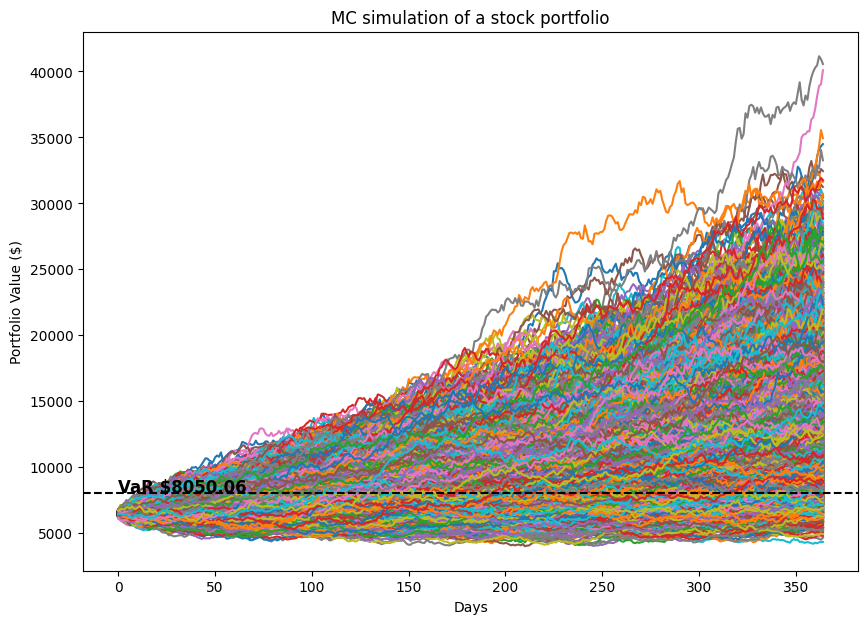

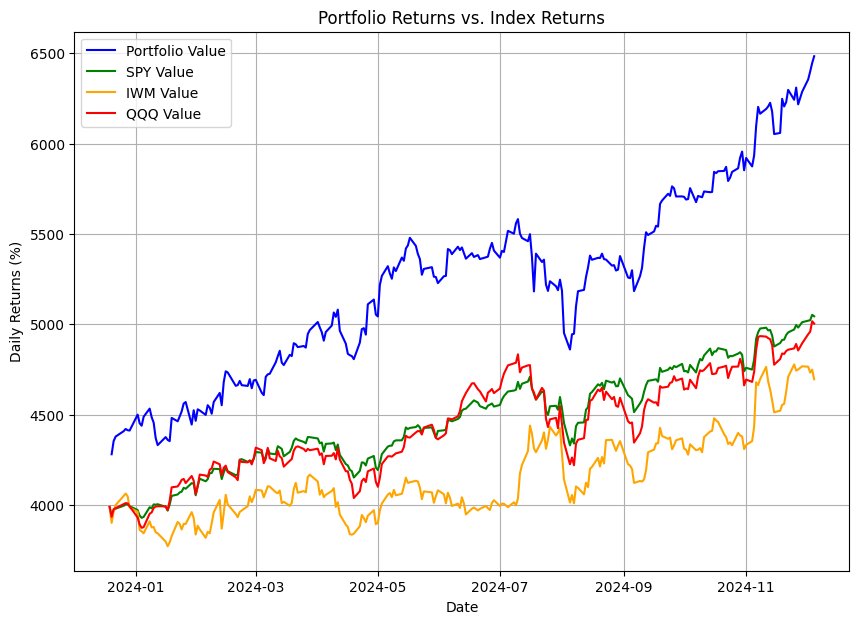

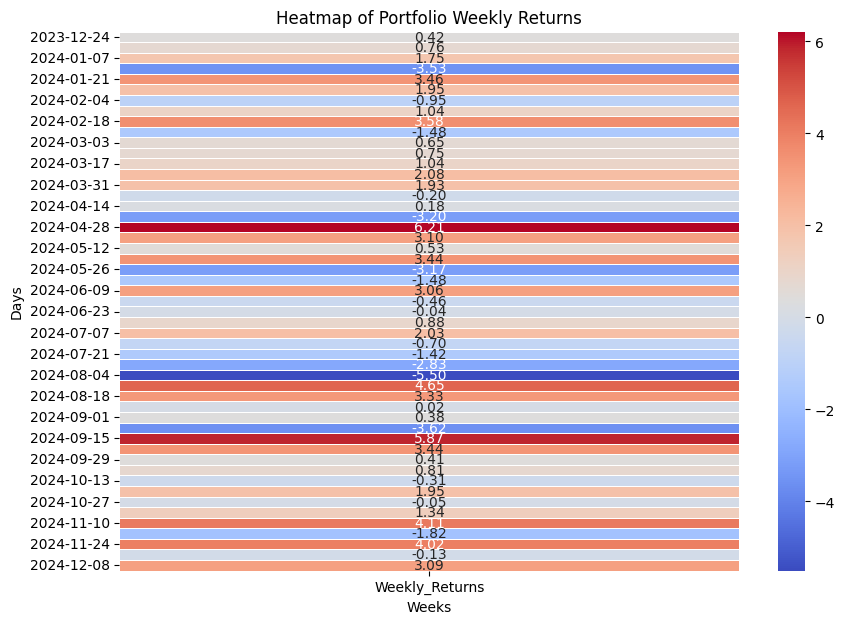

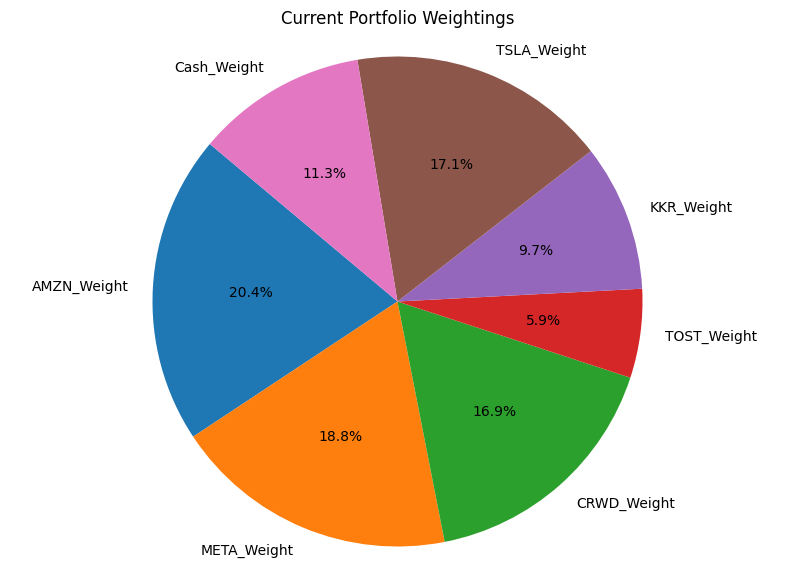

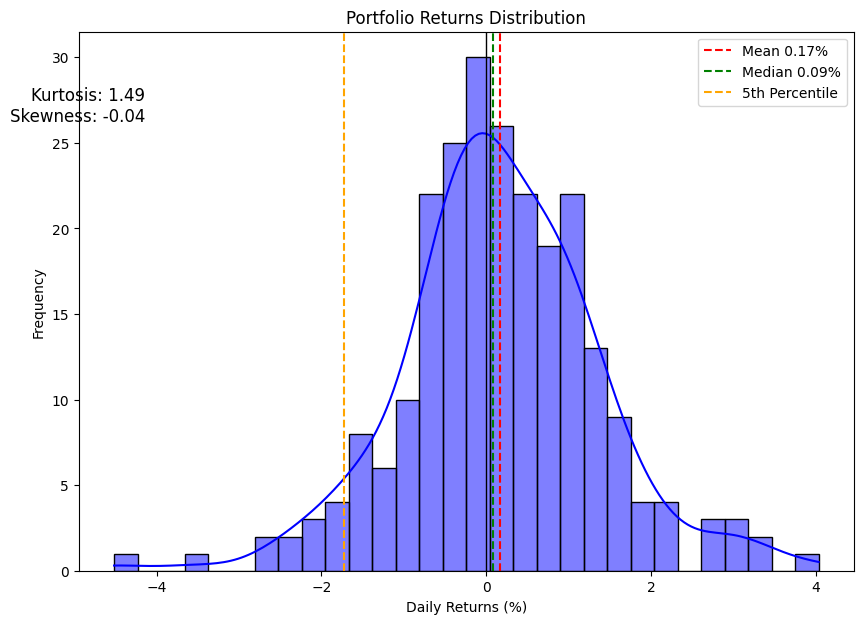

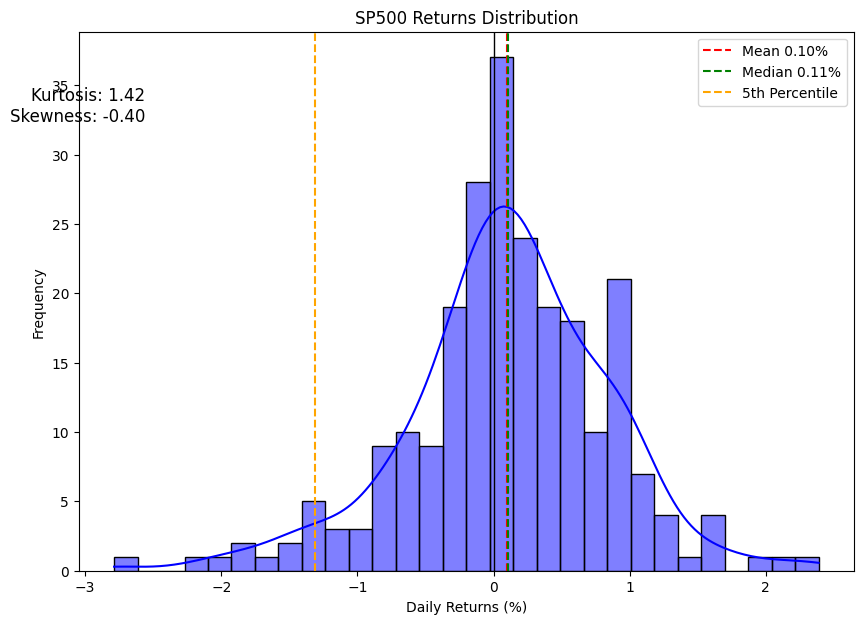

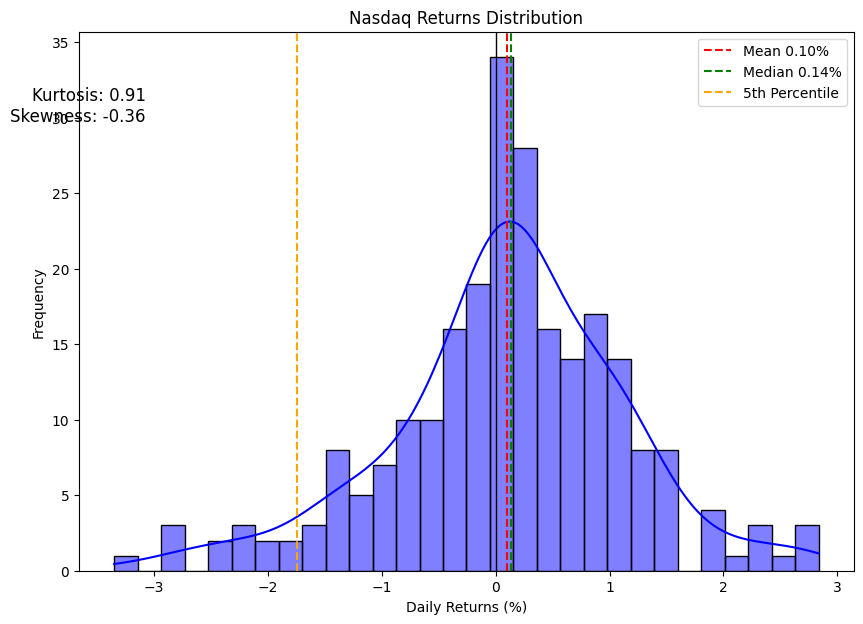

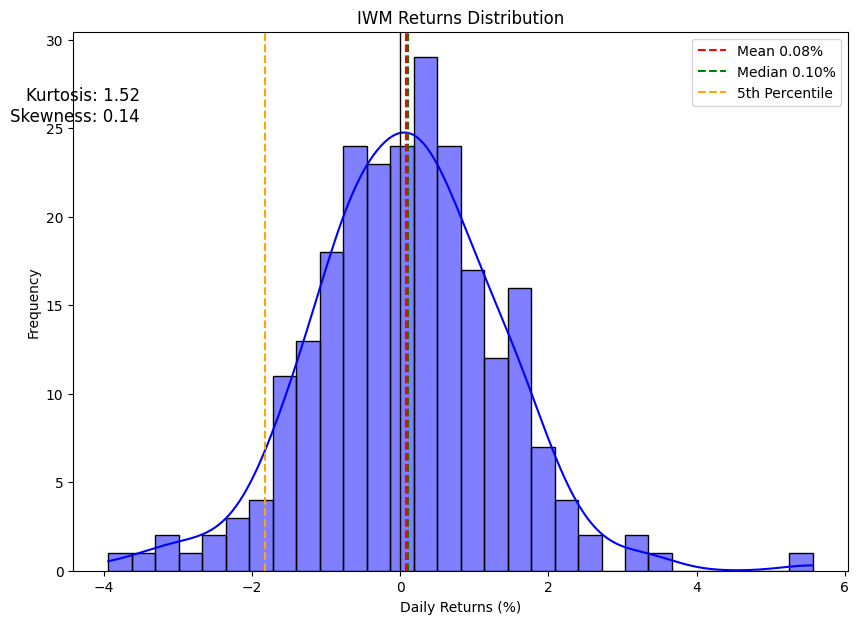

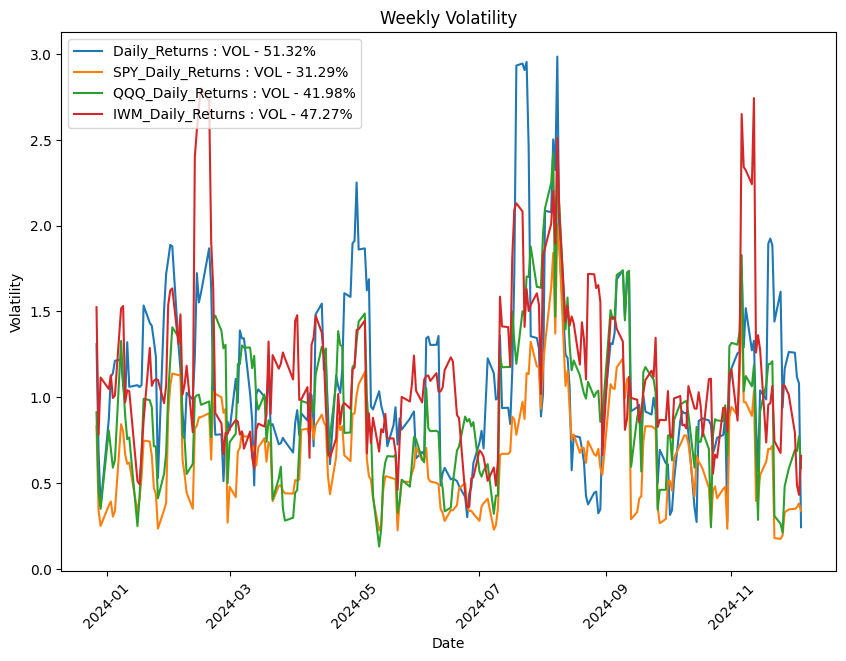

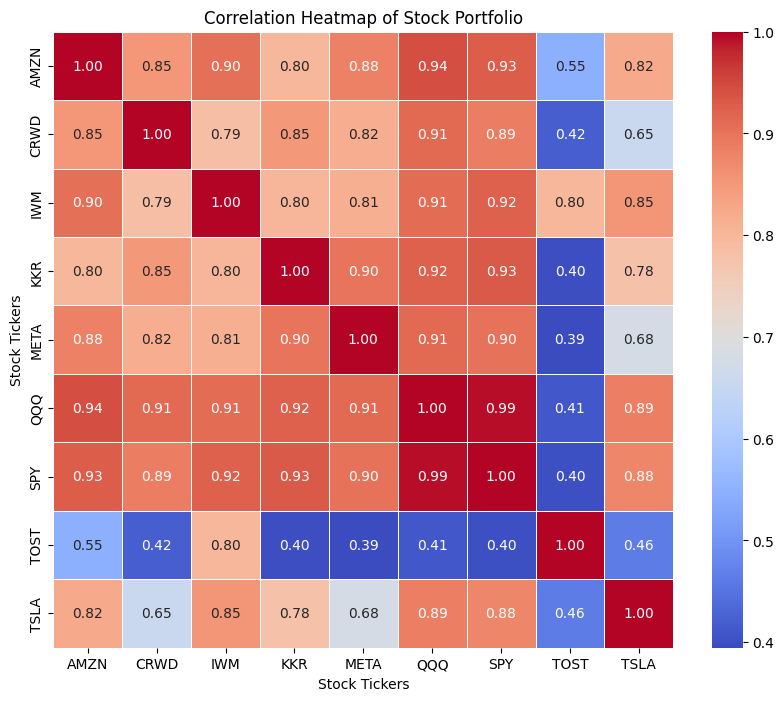

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

def get_data(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end,progress= False)
    stockData = stockData["Close"]  # Use double brackets to ensure DataFrame
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

# Function to get the list of tickers from portfolio data
def get_portfolio_tickers(portfolio_data):
    # Filter tickers where the latest value is greater than 0
    tickers = portfolio_data.columns[portfolio_data.iloc[-1] > 0]
    return tickers

# Fetch latest portfolio data
"""portfolio_data = portfolio_value_data.drop(columns=['Cash', 'Total_Value', 'Returns', 'Daily_Returns', 'Cumulative_Return', 'Running_Max', 'Drawdown', 'Securities_Value','FSLR_Weight',
 'C_Weight',
 'JD_Weight',
 'BABA_Weight',
 'GOOG_Weight',
 'AMZN_Weight',
 "NTLA_Weight",
 "AMD_Weight",
 'Cash_Weight'])
 """

columns_to_drop = ['Cash', 'Total_Value', 'Returns', 'Daily_Returns', 'Cumulative_Return', 'Running_Max', 'Drawdown', 'Securities_Value']

columns_to_drop2 = [str(col) for col in portfolio_value_data.columns if 'weight' in str(col).lower()]

portfolio_data = portfolio_value_data.drop(columns=columns_to_drop + columns_to_drop2)

# Get tickers from portfolio data
tickers = get_portfolio_tickers(portfolio_data)

# Add cash to the list of tickers if not already present
if 'Cash' not in tickers:
    tickers = tickers.append(pd.Index(['Cash']))

# Add a cash column with the most recent cash value
cash_value = portfolio_value_data["Cash"].iloc[-1]
portfolio_data["Cash"] = cash_value

# Calculate total portfolio value
total_portfolio_value = portfolio_value_data["Total_Value"].iloc[-1]

# Calculate weights of each asset
weights = portfolio_data.iloc[-1] / total_portfolio_value

# Sort weights according to the order of tickers
sorted_weights = weights[tickers]

# Normalize weights
normalized_weights = sorted_weights / sorted_weights.sum()

# Display the normalized weights


# Fetch latest mean returns and covariance matrix for the tickers
# Fetch latest mean returns and covariance matrix for the tickers
startDate = dt.datetime.now() - dt.timedelta(days=300)
endDate = dt.datetime.now()
meanReturns, covMatrix = get_data(list(tickers), startDate, endDate)


# Ensure meanReturns matches the number of assets
meanReturns = meanReturns[:len(tickers)]

# Set the mean return for cash to 0
meanReturns = meanReturns.drop(columns=['CASH'])
meanReturns['CASH'] = 0

mc_sims = 10000  # great numbers to test out number of simulations the it will run 
T = 365  # timeframe in days 

meanM = np.full(shape=(T, len(tickers)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = total_portfolio_value  # this is the number assigned to the portfolio initally

for m in range(0, mc_sims):  # T = Timeframe in days 
    # MC Loops       (T * Number of stocks we have) 
    Z = np.random.normal(size=(T, len(tickers)))
    L = np.linalg.cholesky(covMatrix)  # finds lower triangle for Cholesky Decompesition
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:, m] = np.cumprod(np.inner(normalized_weights, dailyReturns.T) + 1) * initialPortfolio  # This accounts for the cumlative effect of daily Return

def mcVAR(returns, alpha = 5 ):
    "Input : pandas series of returns"
    "Output: CVar or Expected Shortfall to a given confidence level alpha"
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError ("Expected a pandas data series.")
    
    
def mcCVAR(returns, alpha = 5 ):
    "Input : pandas series of returns"
    "Output: McCVar or Expected Shortfall to a given confidence level alpha"
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVAR(returns, alpha = alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError ("Expected a pandas data series.")
    
    
portResults = pd.Series(portfolio_sims[-1,:])

perc_95=np.percentile(portfolio_sims[-1], 95)
perc_5=np.percentile(portfolio_sims[-1], 5)
perc_50=np.percentile(portfolio_sims[-1], 50)

VaR = initialPortfolio - mcVAR(portResults, alpha = 5)
CVaR = initialPortfolio -  mcCVAR(portResults, alpha = 5)


print("Value at Risk ${}".format(round(VaR,2)))
print("CVaR ${}".format(round(CVaR,2)))
print("                        ")
print("95th percentile a year out ${}".format(round(perc_95,2)))
print("50th percentile a year out ${}".format(round(perc_50,2)))
print("5th percentile a year out ${}".format(round(perc_5,2)))
plt.figure(figsize=(10, 7))

plt.plot(portfolio_sims)
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Days")
plt.title("MC simulation of a stock portfolio")
# Plot the 5th percentile line
plt.axhline(y=perc_5, color='black', linestyle='--', label='5th Percentile')

# Add text above the line
plt.text(0, perc_5 * 1.01, f'VaR ${perc_5:.2f}', color='black', fontsize=12, fontweight='bold')


# Plot portfolio returns
plt.figure(figsize=(10, 7))
plt.plot(portfolio_value_data.index, portfolio_value_data["Total_Value"], label='Portfolio Value', color='blue')

# Plot index returns
plt.plot(final_values.index, final_values['SPY'], label='SPY Value', color='green')
plt.plot(final_values.index, final_values['IWM'], label='IWM Value', color='orange')
plt.plot(final_values.index, final_values['QQQ'], label='QQQ Value', color='red')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.title('Portfolio Returns vs. Index Returns')
plt.legend()
plt.grid(True)
plt.show()
data =  portfolio_value_data["Total_Value"]

# Resample daily returns to weekly frequency and calculate the mean
weekly_returns = portfolio_value_data['Daily_Returns'].resample('W').sum()
# Rename the column to 'Weekly_Returns'
weekly_returns = weekly_returns.rename('Weekly_Returns')

# Format the index to remove the time component
weekly_returns.index = weekly_returns.index.strftime('%Y-%m-%d')

# Create a heatmap for portfolio's weekly returns
plt.figure(figsize=(10, 7))
sns.heatmap(weekly_returns.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Portfolio Weekly Returns')
plt.ylabel('Days')
plt.xlabel('Weeks')
plt.show() 
# Plot daily returns of portfolio and indices



# Clean the DataFrame columns by converting NaN to a string or removing it
portfolio_value_data.columns = [str(col) if pd.isna(col) else col for col in portfolio_value_data.columns]

# Get the latest row from the DataFrame as a Series
latest_weights_series = portfolio_value_data.iloc[-1]

# Filter out the columns to only include weights and positive, nonzero values
positive_nonzero_weight_columns = [col for col in portfolio_value_data.columns if 'Weight' in col and latest_weights_series[col] > 0]

# Get the current positive and nonzero weights from the latest_weights_series
current_positive_nonzero_weights = latest_weights_series[positive_nonzero_weight_columns]

plt.figure(figsize=(10, 7));
plt.pie(current_positive_nonzero_weights, labels=current_positive_nonzero_weights.index, autopct='%1.1f%%', startangle=140);
plt.title('Current Portfolio Weightings');
plt.axis('equal');  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show();



for col in returns_df.columns:
    kurtosis = returns_df[col].kurtosis()
    skewness = returns_df[col].skew()

    # Plot the distribution of portfolio returns
    plt.figure(figsize=(10, 7))
    sns.histplot(returns_df[col], kde=True, color='blue', bins=30)

    # Annotate kurtosis and skewness on the plot
    plt.axvline(returns_df[col].mean(), color='red', linestyle='--', label=f'Mean {returns_df[col].mean():.2f}%')
    plt.axvline(returns_df[col].median(), color='green', linestyle='--', label=f'Median {returns_df[col].median():.2f}%')

    if col == "Daily_Returns":
        plt.title("Portfolio Returns Distribution")
    elif col == "SPY_Daily_Returns":
        plt.title("SP500 Returns Distribution")
    elif col == "QQQ_Daily_Returns":
        plt.title("Nasdaq Returns Distribution")
    else: 
        plt.title("IWM Returns Distribution")
    
    plt.xlabel('Daily Returns (%)')
    plt.ylabel('Frequency')
    plt.axvline(0, color='black', linestyle='-', linewidth=1)
    plt.axvline(np.percentile(returns_df[col], 5), color='orange', linestyle='--', label='5th Percentile')
    plt.annotate(f'Kurtosis: {kurtosis:.2f}\nSkewness: {skewness:.2f}',
                xy=(0.05, 0.95), xycoords='axes fraction',
                xytext=(20, -20), textcoords='offset points',
                fontsize=12, ha='right', va='top')
    plt.legend()
    plt.show()



# Step 1: Calculate rolling volatility for each stock
rolling_volatility_data = returns_df.rolling(window=5).std()

# Step 2: Plot the rolling volatility of all stocks as a time series
plt.figure(figsize=(10, 7))
for col in rolling_volatility_data.columns:
    plt.plot(rolling_volatility_data.index, rolling_volatility_data[col], label=f"{col} : VOL - {rolling_volatility_data[col].std()*100:.2f}%")

plt.title("Weekly Volatility")
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.legend()
plt.show()



def get_stock_data(tickers, start_date, end_date):
    """
    Fetches historical stock data from Yahoo Finance.
    
    Args:
    - tickers: list of stock tickers (strings)
    - start_date: start date in 'YYYY-MM-DD' format
    - end_date: end date in 'YYYY-MM-DD' format
    
    Returns:
    - DataFrame containing adjusted close prices for the specified tickers
    """
    data = yf.download(tickers, start=start_date, end=end_date,progress= False)['Close']
    return data

def calculate_correlation(portfolio):
    """
    Calculates the correlation matrix of a stock portfolio.
    
    Args:
    - portfolio: DataFrame containing adjusted close prices of stocks
    
    Returns:
    - DataFrame containing correlation matrix
    """
    correlation_matrix = portfolio.corr()
    return correlation_matrix


tickers_list = ["SPY", "QQQ", "IWM"] 

portticks = tickers.to_list()

tickers_list.extend(portticks)

tickers_list.remove("Cash")
    
correlation_start_date = '2014-01-01'
correlation_end_date = datetime.today()
    
    # Get stock data
portfolio = get_stock_data(tickers_list, correlation_start_date, correlation_end_date)
    
    # Calculate correlation matrix
correlation_matrix = calculate_correlation(portfolio)
    
    # Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Stock Portfolio')
plt.xlabel('Stock Tickers')
plt.ylabel('Stock Tickers')
plt.show()


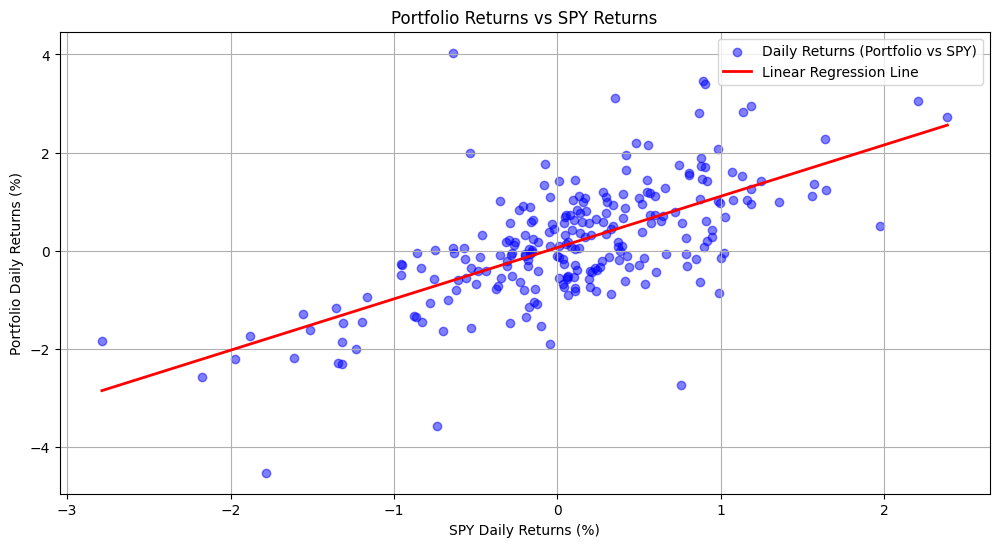

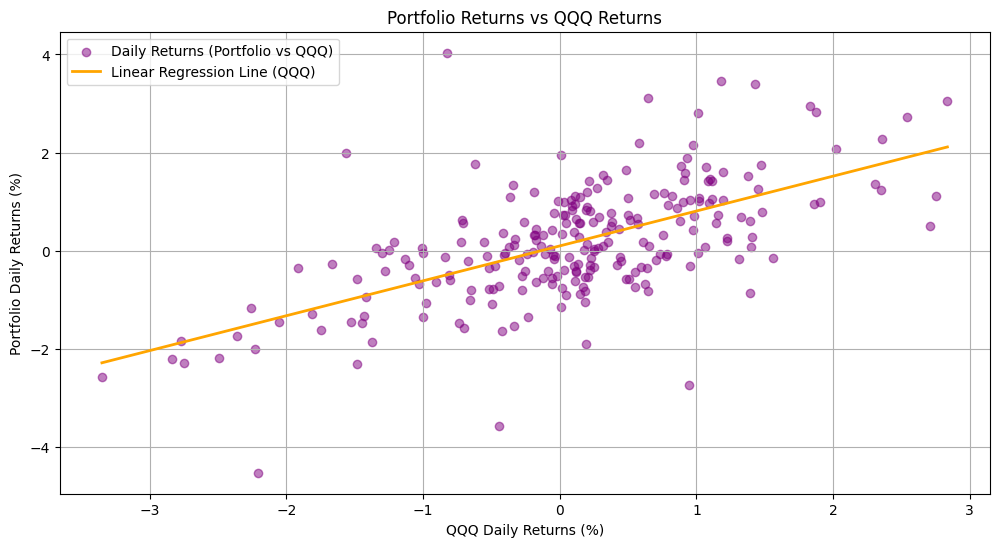

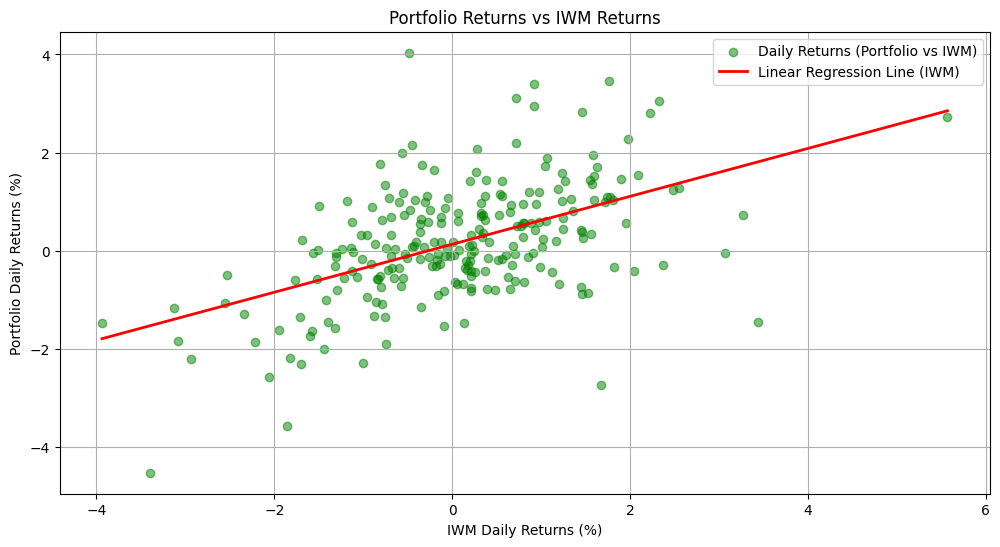

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Prepare data for regression
portfolio_returns = returns_df['Daily_Returns'].values.reshape(-1, 1)  # Portfolio returns as Y
SPY_returns = returns_df['SPY_Daily_Returns'].values.reshape(-1, 1)    # SPY returns as X
iwm_returns = returns_df['IWM_Daily_Returns'].values.reshape(-1, 1)    # IWM returns as X
qqq_returns = returns_df['QQQ_Daily_Returns'].values.reshape(-1, 1)    # QQQ returns as X

# Initialize and fit the Linear Regression model
model_SPY = LinearRegression()
model_SPY.fit(SPY_returns, portfolio_returns)

# Make predictions for SPY returns (to plot the regression line)
SPY_returns_pred = np.linspace(SPY_returns.min(), SPY_returns.max(), 100).reshape(-1, 1)
portfolio_pred = model_SPY.predict(SPY_returns_pred)

model_iwm = LinearRegression()
model_iwm.fit(iwm_returns, portfolio_returns)

# Predictions for plotting the regression line for IWM
iwm_returns_pred = np.linspace(iwm_returns.min(), iwm_returns.max(), 100).reshape(-1, 1)
portfolio_pred_iwm = model_iwm.predict(iwm_returns_pred)


# Initialize and fit the Linear Regression model for QQQ
model_qqq = LinearRegression()
model_qqq.fit(qqq_returns, portfolio_returns)

# Predictions for plotting the regression line for QQQ
qqq_returns_pred = np.linspace(qqq_returns.min(), qqq_returns.max(), 100).reshape(-1, 1)
portfolio_pred_qqq = model_qqq.predict(qqq_returns_pred)



# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(SPY_returns, portfolio_returns, color='blue', alpha=0.5, label='Daily Returns (Portfolio vs SPY)')
plt.plot(SPY_returns_pred, portfolio_pred, color='red', linewidth=2, label='Linear Regression Line')

# Annotations and labels
plt.xlabel('SPY Daily Returns (%)')
plt.ylabel('Portfolio Daily Returns (%)')
plt.title('Portfolio Returns vs SPY Returns')
plt.legend()
plt.grid(True)

plt.show()

# Plotting for QQQ
plt.figure(figsize=(12, 6))
plt.scatter(qqq_returns, portfolio_returns, color='purple', alpha=0.5, label='Daily Returns (Portfolio vs QQQ)')
plt.plot(qqq_returns_pred, portfolio_pred_qqq, color='orange', linewidth=2, label='Linear Regression Line (QQQ)')
plt.xlabel('QQQ Daily Returns (%)')
plt.ylabel('Portfolio Daily Returns (%)')
plt.title('Portfolio Returns vs QQQ Returns')
plt.legend()
plt.grid(True)
plt.show()

# Plotting for IWM
plt.figure(figsize=(12, 6))
plt.scatter(iwm_returns, portfolio_returns, color='green', alpha=0.5, label='Daily Returns (Portfolio vs IWM)')
plt.plot(iwm_returns_pred, portfolio_pred_iwm, color='red', linewidth=2, label='Linear Regression Line (IWM)')
plt.xlabel('IWM Daily Returns (%)')
plt.ylabel('Portfolio Daily Returns (%)')
plt.title('Portfolio Returns vs IWM Returns')
plt.legend()
plt.grid(True)
plt.show()



